# View ROMY event

## Import Libraries

In [8]:
import numpy as np 
import matplotlib.pyplot as plt
import sys, os
import obspy 

from andbro__querrySeismoData import __querrySeismoData
from andbro__savefig import __savefig

In [41]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [42]:
def __read_event_info(config):
    
    from obspy import UTCDateTime
    
    tbeg = input("Enter UTC starttime (2022-06-01 12:00): ") or None
    tend = input("Enter UTC endtime   (2022-06-01 15:00): ") or None
    
    if tbeg is None or tend is None:
        print(" -> Starttime or endtime not correct! Aborting...")
        sys.exit()
    else:
        config['tbeg'] = UTCDateTime(tbeg)
        config['tend'] = UTCDateTime(tend)
        
    if config['tbeg'] > config['tend']:
        print(" -> Starttime is after endtime! Aborting...")
        sys.exit()
        
    return config

## Configurations

In [83]:
## create config object
config = {}

## set path for figures
config['outpath_figs'] = data_path+"ROMY/EventPlots"

config['path_to_archive'] = archive_path+"romy_archive/"

## 
config['tbeg'] = obspy.UTCDateTime("2023-02-06 10:20")
config['tend'] = obspy.UTCDateTime("2023-02-06 13:20")


# ## get event details
# # config = __read_event_info(config)

## saving_options
config['save_figs']   = True

config['save_stream'] = False

config['save_config'] = False

## filter
config['set_filter'] = False

# ## set stations
config['seeds'] = ["BW.RLAS..BJZ", "BW.ROMY.10.BJZ", "BW.ROMY..BJU", "BW.ROMY..BJV", "BW.ROMY..BJW"]

config['repository'] = "george"

In [84]:
# from andbro__get_filter_info import __getFilterInfo

# config = __getFilterInfo(config)

## Load Data

 -> reading BW.RLAS..BJZ ...


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


 -> reading BW.ROMY.10.BJZ ...


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


 -> reading BW.ROMY..BJU ...


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


 -> reading BW.ROMY..BJV ...


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


 -> reading BW.ROMY..BJW ...


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


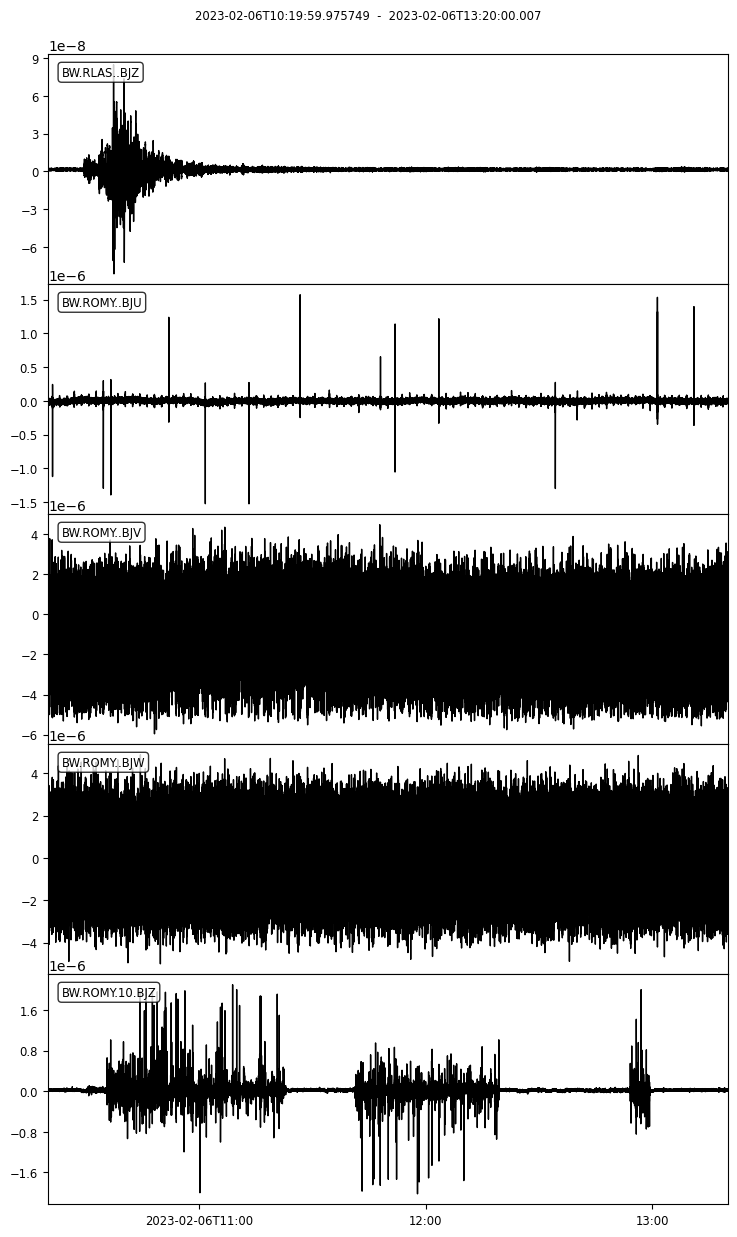

In [85]:
from andbro__read_sds import __read_sds
from andbro__querrySeismoData import __querrySeismoData

st = obspy.Stream()
for seed in config['seeds']:
    
    print(f" -> reading {seed} ...")
    
    if config['repository'] == "archive":
        try:
            st0 = __read_sds(config['path_to_archive'], seed, config['tbeg']-10, config['tend']+10)
            st += st0
        except:
            print(f" -> failed to load: {seed}")            
    elif config['repository'] == "george":
        try:
            st0, inv = __querrySeismoData(    
                                        seed_id=seed,
                                        starttime=config['tbeg']-10,
                                        endtime=config['tend']+10,
                                        repository=config['repository'],
                                        path=None,
                                        restitute=True,
                                        detail=None,
                                        fill_value=None,
                                        )
            st += st0
        except:
            print(f" -> failed to load: {seed}")    


    
st.merge()

st.trim(config['tbeg'], config['tend'])
# st0 = __getStream(config)

st.plot(equal_scale=False);

## Processing

Apply demean and filter as set before.

In [ ]:
from andbro__filterStream import __filterStream
from numpy.ma import is_masked
    
masked = [True  if is_masked(tr.data) else False for tr in st0]

if masked: 
    st0 = st0.split();
    
st0.detrend('simple')
st0.taper(0.1)

st = __filterStream(st0, config)

if masked:
    st.merge();
    
# st.plot(equal_scale=False);

## Plot Spectra

In [ ]:
def __makeplot_sectra(st, config):
    
    from scipy import fftpack

    plt.style.use('default')


    fig, axes = plt.subplots(5,2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):


        comp_fft = np.abs(fftpack.fft(tr.data))
        ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
        comp_fft = fftpack.fftshift(comp_fft)


        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()/60,
                    tr.data,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].plot(
                    ff[1:len(ff)//2],
                    np.abs(fftpack.fft(tr.data)[1:len(ff)//2]),
                    color='black',
                    lw=1.0,
                    )


        
        axes[i,0].set_ylabel(r'$\Omega$ (rad/s)')    
        axes[i,1].set_ylabel('ASD (rad/s/Hz)')        
#         axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        axes[i,0].annotate('{} {}'.format(tr.stats.station, tr.stats.channel), 
                           xy=(0.4,0.928+i*-0.181),
                           xycoords='figure fraction', 
                           )
        axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
        if config['set_filter']:
            if config['filter_type'] == "bandpass":
                axes[i,1].annotate('{}-{} Hz'.format(config['lower_corner_frequency'], config['upper_corner_frequency']), xy=(0.88,0.90+i*-0.18), xycoords='figure fraction')
            elif config['filter_type'] == "lowpass":
                axes[i,1].annotate('<{} Hz'.format(config['upper_corner_frequency']), xy=(0.88,0.90+i*-0.18), xycoords='figure fraction')
            elif config['filter_type'] == "highpass":
                axes[i,1].annotate('>{} Hz'.format(config['lower_corner_frequency']), xy=(0.88,0.90+i*-0.18), xycoords='figure fraction')

            if config['upper_corner_frequency'] is not None:
                axes[i,1].set_xlim(0, 1.5*config['upper_corner_frequency'])
                
#         axes[i,1].set_yscale('logit')

        if i == len(st)-1:
            axes[i,0].set_xlabel('Time (min)  from {} {} UTC'.format(tr.stats.starttime.date, str(tr.stats.starttime.time)[0:8]))
            axes[i,1].set_xlabel('Frequency (Hz)')
    
    
    ## save figure if specified in configurations
    if config['save_figs']:
        __savefig(fig, outpath=config['outpath_figs'], outname=f"TraceSpectrum_{config['tbeg'].date}"+".png", mode="png");

    return fig


## __________________________________

fig = __makeplot_sectra(st, config)

## Write Data

In [86]:
stout = st.select(station="RLAS")

stout.write(root_path+"Downloads/"+f"RLAS_{config['tbeg']}_{config['tend']}.mseed")

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [87]:
!ls /home/andbro/Downloads/*mseed

'/home/andbro/Downloads/BW.ROMYT..MA*.2022.mseed'
'/home/andbro/Downloads/BW.TROMY..MA*.2021.mseed'
'/home/andbro/Downloads/BW.TROMY..MA*.2022.mseed'
 /home/andbro/Downloads/RLAS_2023-02-06T01:00:00.000000Z_2023-02-06T02:00:00.000000Z.mseed
 /home/andbro/Downloads/RLAS_2023-02-06T10:20:00.000000Z_2023-02-06T13:20:00.000000Z.mseed

/home/andbro/Downloads/mseed:
2022
